Importing libraries

In [57]:
from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np
from typing import Tuple, List
from attr import define
import os
import time

In [58]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


Utility functions

In [59]:
def normalize_ndarray(array: np.ndarray) -> np.ndarray:

    max = np.max(array)
    min = np.min(array)

    if (max - min) == 0:
        return array
    else:
        return (array - min) / (max - min)


def show_dataset(
    x_data_left: np.array, x_data_right: np.array, y_data: np.array, num_images: int
) -> None:
    fig1, ax = plt.subplots(num_images, 2, figsize=(2.4, num_images * 1.2))
    for i in range(num_images):
        ax[i, 0].imshow(x_data_left[i], cmap="binary", vmax=1)
        ax[i, 1].imshow(x_data_right[i], cmap="binary", vmax=1)

        ax[i, 1].text(45, 18, f"{y_data[i]}", fontsize=20)

        ax[i, 0].set_xticks([])
        ax[i, 0].set_yticks([])
        ax[i, 1].set_xticks([])
        ax[i, 1].set_yticks([])

    plt.show()


def show_single_digit(x_data, y_data, index, print_index: bool):
    image = x_data[index]
    digit = y_data[index]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(3, 3))

    ax1.imshow(image, cmap="binary", vmax=1)
    ax1.set_title("Image")
    ax1.set_aspect("equal")
    ax1.set_xticks([])
    ax1.set_yticks([])

    if not print_index:
        ax2.set_title("Digit")
        ax2.text(0.4, 0.5, f"{digit}", fontsize=20)
    else:
        ax2.set_title("Index")
        ax2.text(0.4, 0.5, f"{index}", fontsize=20)

    ax2.set_aspect("equal")
    ax2.axis("off")

    plt.show()


def show_double_digit(x_data_left, x_data_right, y_data, index):
    image_left = x_data_left[index]
    image_right = x_data_right[index]
    digit = y_data[index]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(3, 3))

    ax1.imshow(image_left, cmap="binary", vmax=1)
    ax1.set_title("Image")
    ax1.set_aspect("equal")
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.imshow(image_right, cmap="binary", vmax=1)
    ax2.set_title("Image")
    ax2.set_aspect("equal")
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax3.set_title("Digit")
    ax3.text(0.4, 0.5, f"{digit}", fontsize=20)
    ax3.set_aspect("equal")
    ax3.axis("off")

    plt.show()

def get_current_time_string() -> str:
    current_time = time.localtime()
    return f'{current_time.tm_year}-{current_time.tm_mon}-{current_time.tm_mday}_{current_time.tm_hour}-{current_time.tm_min}-{current_time.tm_sec}'

Generating dataset functions

In [60]:
def shuffle_visual_field_dataset(
    x_data: np.array, y_data: np.array
) -> Tuple[np.array, np.array]:
    # shuffles dataset comprised of two arrays

    n = len(y_data)
    unique_indices = np.random.permutation(
        n
    )  # generates random permutation of list in range(0, n)
    x_data = x_data[unique_indices]
    y_data = y_data[unique_indices]

    return x_data, y_data


def shuffle_two_visual_fields_dataset(
    x_data_left: np.array, x_data_right: np.array, y_data: np.array
) -> Tuple[np.array, np.array, np.array]:
    # Shuffles dataset comprised of three arrays

    n = len(y_data)
    unique_indices = np.random.permutation(
        n
    )  # generates random permutation of list in range(0, n)
    x_data_left = x_data_left[unique_indices]
    x_data_right = x_data_right[unique_indices]
    y_data = y_data[unique_indices]

    return x_data_left, x_data_right, y_data


def shuffle_and_double_dataset(
    x_data: np.array, y_data: np.array
) -> Tuple[np.array, np.array]:
    x_data1, y_data1 = shuffle_visual_field_dataset(x_data, y_data)
    x_data2, y_data2 = shuffle_visual_field_dataset(x_data, y_data)

    x_data_concatenated = np.concatenate((x_data1, x_data2))
    y_data_concatenated = np.concatenate((y_data1, y_data2))

    return x_data_concatenated, y_data_concatenated


def build_visual_field_data(
    x_data: np.array, y_data: np.array, n: float
) -> Tuple[np.array, np.array]:
    """
    Builds the dataset for a single visual field, choosing random values from the input.

    Input:
    x_data: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset.
    y_data: np.array(int): corresponding value of the digit represented by x_data.
    n: float: size of the final dataset

    Output:
    x_data_right: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset.
    y_data: np.array(int): corresponding value of the digit of the visual field.
    """

    original_size = len(y_data)
    random_indices = np.random.choice(np.arange(0, original_size), n)
    x_data_visual_field = x_data[random_indices]
    y_data_visual_field = y_data[random_indices]

    return x_data_visual_field, y_data_visual_field


def build_double_visual_fields_dataset(
    x_data: np.array,
    y_data: np.array,
    final_size: float = 4,
    proportion_cs: float = 0.5,
    proportion_left: float = 0.5,
    full_attention_value: float = 1,
    reduced_attention_value: float = 0.5,
    ss_attention_value: float = 0.5,
) -> Tuple[np.array, np.array, np.array]:
    """
    Builds an entire double visual fields dataset, comprised of two visual fields, left and right, and an array of the corresponding answer value for both visual fields.

    Input:
    x_data: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset.
    y_data: np.array(int): corresponding value of the digit represented by x_data.
    final_size: float: how many times the final dataset is bigger than the input data. Default is 4.
    proportion_cs: float: proportion of entries in the final dataset that have CS over SS. Default is 0.5.
    proportion_left: float: proportion of entries in the final dataset that have attention on the left visual field. Default is 0.5.
    full_attention_value: float: value of the full attention in CS. Default is 1.
    reduced_attention_value: float: value of the reduced attention in CS. Default is 0.5.
    ss_attention_value: float: value of the attention for SS. Default is 0.5.

    Output:
    x_data_left: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset with a determined attention.
    x_data_right: np.array(np.ndarray): array of two-dimensional arrays corresponding to the pixel values of digits of the MNIST dataset with a determined attention.
    y_data: np.array(int): corresponding value of the digit that has most attention considering both visual fields.
    """

    n = len(y_data) * final_size
    x_data_left, y_data_left = build_visual_field_data(x_data, y_data, n)
    x_data_right, y_data_right = build_visual_field_data(x_data, y_data, n)

    y_data_final = np.zeros(n, dtype=int)
    for i in range(n):
        data_with_cs = np.random.choice(
            [False, True], p=[1 - proportion_cs, proportion_cs]
        )
        data_with_left_attention = np.random.choice(
            [False, True], p=[1 - proportion_left, proportion_left]
        )

        # determines value of attention if dataset entry is CS or SS
        if data_with_cs:
            attention = full_attention_value
            no_attention = reduced_attention_value
        else:
            attention = ss_attention_value
            no_attention = 0

        # determines which visual field has attention
        if data_with_left_attention:
            x_data_left[i] *= attention
            x_data_right[i] *= no_attention
            y_data_final[i] = y_data_left[i]
        else:
            x_data_left[i] *= no_attention
            x_data_right[i] *= attention
            y_data_final[i] = y_data_right[i]

    return x_data_left, x_data_right, y_data_final

Importing dataset and normalizing input

In [61]:
mnist_dataset = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_dataset.load_data()
x_train = normalize_ndarray(x_train)
x_test = normalize_ndarray(x_test)

Building training dataset

In [62]:
x_train_left, x_train_right, y_train_final = build_double_visual_fields_dataset(
    x_train,
    y_train,
    final_size=4,
    proportion_cs=0.5,
    proportion_left=0.5,
    full_attention_value=1,
    reduced_attention_value=0.5,
    ss_attention_value=0.5,
)

Showing training dataset

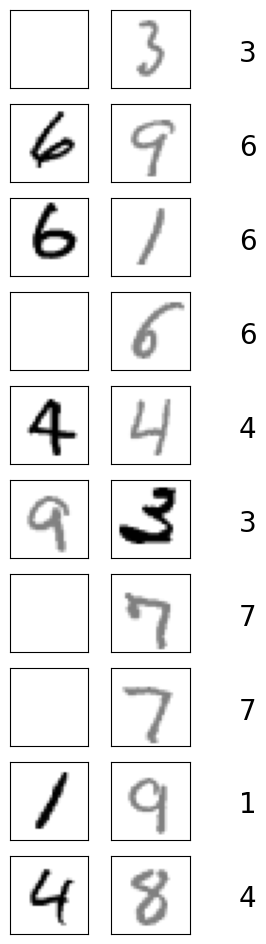

In [63]:
show_dataset(x_train_left, x_train_right, y_train_final, 10)

Building testing dataset

In [64]:
x_test_left, x_test_right, y_test_final = build_double_visual_fields_dataset(
    x_test,
    y_test,
    final_size=1,
    proportion_cs=0.5,
    proportion_left=0.5,
    full_attention_value=1,
    reduced_attention_value=0.5,
    ss_attention_value=0.5,
)

Showing testing dataset

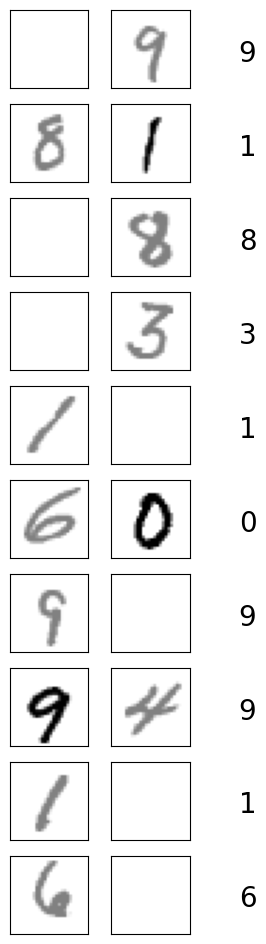

In [65]:
show_dataset(x_test_left, x_test_right, y_test_final, 10)

**Visualizing Neural Networks**

Plotting Neural Network dataclasses

In [66]:
@define
class Position:
    """
    Class representing a position with two coordinates
    """

    x: float
    y: float

    def copy(self):
        return Position(self.x, self.y)

    def __str__(self):
        return f"Position({self.x}, {self.y})"


@define
class Neuron:
    """
    Class representing a neuron in the Neural Network plot
    """

    activation: float
    position: Position
    radius: float


@define
class Layer:
    """
    Class representing a layer in the Neural Network plot
    """

    model: keras.layers
    activations: List[float] | None = None
    position: Position | None = None
    neurons: List[Neuron] | None = None
    num_neurons: int | None = None

    def __attrs_post_init__(self):
        self.neurons = ([])  # This is needed to solve bug where list is not empty at start
        self.num_neurons = self.model.output_shape[-1]

    def is_output_layer(self):
        return not bool(self.model._outbound_nodes)

    def set_y_position(self, y_position):
        self.position.y = y_position

Auxiliary functions

In [67]:
def get_index_of_digit(y_data, digit):
    """
    Return index of first occurance of digit in the dataset, if digit is not found, returns -1
    """
    n = len(y_data)
    index = 0
    while y_data[index] != digit and index < n - 1:
        index += 1

    return index if y_data[index] == digit else -1


def get_single_visual_field_digit(x_data, y_data, digit):
    """
    Returns the first instance of the digit in the Single Visual Field dataset
    """
    index = get_index_of_digit(y_data, digit)

    return np.array([x_data[index]])


def get_double_visual_field_digit(x_data_left, x_data_right, y_data, digit):
    """
    Returns the first instance of the digit in the Double Visual Field dataset
    """
    index = get_index_of_digit(y_data, digit)
    if index == -1:
        print("Error! Digit wasn't found!")

    return np.array([x_data_left[index]]), np.array([x_data_right[index]])


def get_activations_single_visual_field(model, input_digit, x_data, y_data):
    """
    Generates the individual neuron activation values for a prediction with a single visual field Neural Network
    """

    # Creating intermediate models
    intermediate_layer_models = [
        keras.models.Model(
            inputs=model.input, outputs=layer.output
        )
        for layer in model.layers
    ]

    # Getting activations
    input_data = get_single_visual_field_digit(x_train, y_train, input_digit)
    activations = [
        intermediate_layer_model(input_data, training=False)[0]
        for intermediate_layer_model in intermediate_layer_models
    ]  # Predict result is returned inside a list, hence we get the first element of that list

    return activations

def get_activations_double_visual_field(
    model,
    x_data=None,
    left_vf_digit: Tuple[int, float] = None,
    right_vf_digit: Tuple[int, float] = None,
    x_data_left=None,
    x_data_right=None,
    input_digit=None,
    y_data=None,
):
    """
    Generates the individual neuron activation values for a prediction with a double visual field Neural Network
    """

    # Creating intermediate models
    intermediate_layer_models = [
        keras.models.Model(
            inputs=model.input, outputs=layer.output
        )
        for layer in model.layers
    ]

    # Getting activations
    if left_vf_digit is None:
        input_data_left, input_data_right = get_double_visual_field_digit(
            x_data_left, x_data_right, y_data, input_digit
        )
    else:
        left_idx, left_attention = left_vf_digit
        input_data_left = np.array([x_data[left_idx]]) * left_attention
        right_idx, right_attention = right_vf_digit
        input_data_right = np.array([x_data[right_idx]]) * right_attention
    activations = [
        intermediate_layer_model([input_data_left, input_data_right], training=False)[0]
        for intermediate_layer_model in intermediate_layer_models
    ]   # Model result is returned inside a list, hence we get the first element of that list

    return activations


def get_image(neural_activation):
    """
    Transforms the activity of the neurons of a Neural Network into a 2D matrix that can be seen as an image with plt.imshow
    """
    num_neurons = len(neural_activation)
    num_rows = int(np.sqrt(num_neurons))
    num_cols = int(np.ceil(num_neurons / num_rows))

    return np.array(neural_activation).reshape(num_rows, num_cols)


def generate_image_annotation_box(
    image, position, size, border_size=1, border_color="black"
):
    """
    Generates the AB of the image to be positioned in the figure
    """
    img = OffsetImage(image, zoom=size)
    ab = AnnotationBbox(img, (position.x, position.y), frameon=False, pad=0)

    return ab


def generate_image_annotation_box_grayscale(
    image, position, size, border_width=1, border_color="black"
):
    """
    Generates the AnnotationBbox of the grayscale image with a border to be positioned in the figure
    """

    img = OffsetImage(
        image, zoom=size, cmap="binary", norm=plt.Normalize(vmin=0, vmax=1)
    )
    ab = AnnotationBbox(
        img,
        (position.x, position.y),
        frameon=True,
        pad=0,
        bboxprops=dict(
            edgecolor=border_color, linewidth=border_width, boxstyle="square,pad=0.1"
        ),
    )

    return ab


def get_number_of_neurons_in_layer(layer):
    """
    Returns the number of neurons present in a layer of a Neural Network
    """
    return layer.output_shape[-1]


def get_digit_from_y_spacing(total_position_plotted, y_spacing):
    """
    Returns the digit an output neuron represents based on how many neurons have been plotted
    """
    return np.ceil(total_position_plotted / y_spacing)


def calculate_image_size(number_neurons):
    """
    Computes size of image based on the number of neurons
    """
    # Determined in tests
    a = -5 / 1536
    b = 533 / 96
    return number_neurons * a + b


def compute_sizes(top):
    bottom = 1 - top
    return top, bottom, bottom, top  # top, bottom, left, right


def display_n_digits(x_data, y_data, digit: int, n: int):
    size = len(y_data)
    idx = 0
    digits_found = 0
    idx_last_digit = 0
    while idx < size and digits_found < n:
        if y_data[idx] == digit:
            digits_found += 1
            idx_last_digit = idx
            show_single_digit(x_data, y_data, idx, print_index=True)
        idx += 1

def generate_output_models(model):
    # Generate not trainable copy of model
    model_copy = keras.models.clone_model(model)
    model_weights = model.get_weights()
    model_copy.set_weights(model_weights)
    for layer in model_copy.layers:
        layer.trainable = False 
    
    # Generate output models of each hidden layer
    output_models = []
    for layer in model_copy.layers[4:-2]:
        out_model_input = model_copy.input # [left_input, right_input]
        if 'left' in layer.name:
            out_model_input = out_model_input[0]
        elif 'right' in layer.name:
            out_model_input = out_model_input[1]
            
        out_model_output = keras.layers.Dense(10, activation="softmax")(layer.output)
        out_model = keras.models.Model(
        inputs=out_model_input, outputs=out_model_output
        )
        output_models.append(out_model)

    return output_models

def show_dataset_sizes(*data):
    for d in data:
        print(d.shape)

def data_generator_double_visual_field(x_data_left, x_data_right, y_data, batch_size):
    while True:
        for i in range(0, len(y_data), batch_size):
            yield [x_data_left[i:i+batch_size], x_data_right[i:i+batch_size]], y_data[i:i+batch_size]

def data_generator_single_visual_field(x_data, y_data, batch_size):
    while True:
        for i in range(0, len(y_data), batch_size):
            yield x_data[i:i+batch_size], y_data[i:i+batch_size]
        
def is_double_visual_field_model(model):
    return type(model.input) == list # If input is a list, it is a double visual field model

def is_left_visual_field_model(model):
    return not is_double_visual_field_model(model) and 'left' in model.input.name

def compute_digits_model_predicts(model: keras.Model, *data: np.array) -> List[Tuple[int, float]]:
    '''
        Returns a list with the activations of the output layer of the model for each digit.
        The list is sorted in descending order of activation.

        Input:
        model: keras.Model: model to be used for prediction
        *data: np.array: input data to be used for prediction, could be one or two arrays
        
        Output: [(digit, activation), ...]
    
    '''
    activations = None
    if is_double_visual_field_model(model):
        activations = model([data[0], data[1]], training=False)[0]
    else:
        if is_left_visual_field_model(model):
            activations = model([data[0]], training=False)[0]
        else:
            activations = model([data[1]], training=False)[0]
    
    digit_activations = []
    for digit, activation in enumerate(activations):
        digit_activations.append((digit, activation.numpy()))
    
    digit_activations = sorted(digit_activations, key=lambda item: item[1], reverse=True)
        
    return digit_activations

Single visual field

In [ ]:
def display_single_visual_field_mnist_nn_execution(
    model, x_data, y_data, input_digit, max_neurons, weight_plot_threshold
):
    """
    Receives a trained Neural Network model and and input digit, plotting the full neural network execution
    """

    """ Determining matplotlib figure parameters """

    fig = plt.figure(
        figsize=(12, 12)
    )  # TODO: generate size based on max number of neurons on layer
    ax = fig.gca()
    ax.axis("off")
    left, right, bottom, top = 0.1, 0.9, 0.1, 0.9

    """ Calculating neural network activations """

    model_activations = get_activations_single_visual_field(
        model, input_digit, x_data, y_data
    )

    """ Determining neural network figure parameters """

    model_number_of_layers = len(model.layers)
    layer_spacing = (right - left) / (model_number_of_layers - 1)  # Space between each layer in the plot
    connection_opacity = 0.2
    color_connection_opacity = 0.5
    image_y_position = 0.5
    current_position = Position(left, image_y_position)  # Initial position

    """ Plotting layers """

    plotted_layers = []
    for i in range(model_number_of_layers):
        model_layer = model.layers[i]
        layer_activations = model_activations[i]  # TODO: Can raise error if number of activations not equal to number of layers

        layer = Layer(model=model_layer, activations=layer_activations)
        plotted_layers.append(layer)  # Adding layer to plotted layers

        # Depending on the type of layer, different  figures will be created to represent it

        # -- Flatten layer --
        if "flatten" in layer.model.name:
            # If it is the input layer
            if i == 0:
                layer.position = current_position.copy()
                ab = generate_image_annotation_box_grayscale(
                    get_image(layer.activations),
                    layer.position,
                    size=calculate_image_size(layer.num_neurons),
                )
                ax.add_artist(ab)

        #  -- Dense layer --
        elif "dense" in layer.model.name:

            # -- Plotting neurons of dense layer --
            if layer.num_neurons < max_neurons:  # Plotting individual neurons
                current_position.x += layer_spacing
                current_position.y = top
                layer.position = current_position.copy()

                previous_layer = plotted_layers[i - 1]  # Gets previous layer
                layer_weights = normalize_ndarray(layer.model.get_weights()[0])

                neuron_spacing = (top - bottom) / layer.num_neurons  # Space between each neuron in the plot
                layer_activations = (
                    normalize_ndarray(layer_activations)
                    if not layer.is_output_layer()
                    else layer_activations
                )  # Normalize layer activations if it is not output layer
                for idx, neuron_activation in enumerate(layer_activations):
                    # -- Plotting each neuron --
                    neuron = Neuron(
                        neuron_activation,
                        current_position.copy(),
                        radius=neuron_spacing / 4,
                    )
                    layer.neurons.append(neuron)  # Adding neuron to plotted layer
                    neuron_circle = plt.Circle(
                        xy=(current_position.x, current_position.y),
                        radius=neuron.radius,
                        color=plt.cm.viridis(neuron_activation),
                        ec="k",
                    )
                    ax.add_artist(neuron_circle)  # Plots neuron

                    # -- Plotting connections of neurons to previous layer --
                    if (previous_layer.num_neurons < max_neurons):  # Checks if the number of neurons on the previous layer doesn't exceed the maximum to be plotted)
                        layer_weights_neuron = layer_weights[:, idx]
                        for previous_neuron, connection_weight in zip(previous_layer.neurons, layer_weights_neuron):
                            # Checks if weight is above threshold
                            if connection_weight >= weight_plot_threshold:
                                connection = plt.Line2D(
                                    [
                                        current_position.x - neuron.radius,
                                        previous_neuron.position.x + previous_neuron.radius,
                                    ],
                                    [current_position.y, previous_neuron.position.y],
                                    color=plt.cm.viridis(connection_weight),
                                    alpha=color_connection_opacity,
                                )
                                ax.add_artist(connection)  # Plots connection to previous neurons

                    else:  # In case it does, only a single conncetion from each neuron will be shown connecting to the previous layer
                        previous_layer_position = Position(previous_layer.position.x, previous_layer.position.y)  # Saves position of previous layer
                        image_offset = 0.065
                        connection = plt.Line2D(
                            [
                                current_position.x - neuron.radius,
                                previous_layer_position.x + image_offset
                            ],
                            [current_position.y, previous_layer_position.y],
                            color="k",
                            alpha=connection_opacity,
                        )
                        ax.add_artist(connection)  # Plots connection to image

                    # -- Plotting digit and activation if it is the output layer --
                    if i == model_number_of_layers - 1:
                        neuron_digit = get_digit_from_y_spacing(
                            (top - current_position.y), neuron_spacing
                        )
                        text_offset_x = 0.001
                        text_offset_y = 0.005
                        text = plt.Text(
                            current_position.x + neuron.radius + text_offset_x,
                            current_position.y - text_offset_y,
                            f"{neuron_digit}: {neuron_activation:.4f}",
                            fontsize=8,
                            color="k",
                        )
                        ax.add_artist(text)  # Adds corresponding digit and activation of neuron

                    # Changes the current y position to plot the next neuron
                    current_position.y -= neuron_spacing

            else:  # If the number of neurons in the layer exceeds the maximum TODO: Color connections if previous layer has few neurons
                current_position.x += layer_spacing
                current_position.y = image_y_position
                layer.position = current_position.copy()

                # -- Plotting layer as image --
                ab = generate_image_annotation_box(
                    get_image(layer.activations),
                    layer.position,
                    size=calculate_image_size(layer.num_neurons),
                )
                ax.add_artist(ab)

                # -- Plotting connections of image to previous layer --
                previous_layer = plotted_layers[i - 1]  # Gets previous layer
                if (previous_layer.num_neurons < max_neurons):  # Checks if the number of neurons on the previous layer doesn't exceed the maximum to be plotted
                    for previous_neuron in previous_layer.neurons:
                        connection = plt.Line2D(
                            [
                                current_position.x,
                                previous_neuron.position.x + previous_neuron.radius,
                            ],
                            [current_position.y, previous_neuron.position.y],
                            color="k",
                            alpha=connection_opacity,
                        )
                        ax.add_artist(connection)  # Plots connection to previous neurons
                else:  # If previous layer exceeds the maximum number of neurons plotted
                    connection = plt.Line2D(
                        [current_position.x, previous_layer.position.x],
                        [current_position.y, previous_layer.position.y],
                        color="k",
                        alpha=connection_opacity,
                    )
                    ax.add_artist(connection)  # Plots connection to previous neurons

    fig.savefig("nn.png")

Double visual field

In [76]:
def display_double_visual_field_mnist_nn_execution(
    model,
    max_neurons,
    weight_plot_threshold,
    output_models=None,
    k=2,
    x_data=None,
    left_vf_digit: Tuple[int, float] = None,
    right_vf_digit: Tuple[int, float] = None,
    x_data_left=None,
    x_data_right=None,
    y_data=None,
    input_digit=None,
):
    """
    Receives a trained Neural Network model with two visual fields and and input digit, plotting the full neural network execution.
    Obseravtion: this code currently doesn't support Convolution or MaxPool layers and layers with too many neurons.
    """

    """ Determining matplotlib figure parameters """

    fig = plt.figure(
        figsize=(24, 24)
    )  # TODO: generate size based on max number of neurons on layer
    ax = fig.gca()
    ax.axis("off")
    top, bottom, left, right = compute_sizes(top=0.98)
    precision = 4  # Number of digits of precision when calculating positions
    middle = round((top + bottom) / 2, ndigits=precision)
    middle_spacing = 0.02

    """ Getting input data """

    left_idx, left_attention = left_vf_digit
    input_data_left = np.array([x_test[left_idx]]) * left_attention

    right_idx, right_attention = right_vf_digit
    input_data_right = np.array([x_test[right_idx]]) * right_attention

    """ Calculating neural network activations """

    if left_vf_digit is None:
        model_activations = get_activations_double_visual_field(
            model, input_digit, x_data_left, x_data_right, y_data
        )
    else:
        model_activations = get_activations_double_visual_field(
            model, x_data, left_vf_digit, right_vf_digit
        )

    """ Determining neural network figure parameters """

    model_number_of_layers = len(model.layers)
    layer_spacing = (right - left) / (model_number_of_layers - 1)  # Space between each layer in the plot
    connection_opacity = 0.2
    color_connection_opacity = 0.5
    left_vf_position = Position(left, 1.5 * middle)  # Initial position of left visual field
    right_vf_position = Position(left, 0.5 * middle)  # Initial position of right visual field

    """ Plotting layers """

    plotted_layers_left_vf = []
    plotted_layers_right_vf = []
    plotted_layers_concatenated = []
    layers_reference = None

    # Input layers

    # Left
    input_layer_left = Layer(model=model.layers[2], activations=model_activations[2])
    input_layer_left.position = left_vf_position.copy()
    ab = generate_image_annotation_box_grayscale(
        get_image(input_layer_left.activations),
        input_layer_left.position,
        size=calculate_image_size(input_layer_left.num_neurons),
    )
    ax.add_artist(ab)
    plotted_layers_left_vf.append(input_layer_left)

    # Right
    input_layer_right = Layer(model=model.layers[3], activations=model_activations[3])
    input_layer_right.position = right_vf_position.copy()
    ab = generate_image_annotation_box_grayscale(
        get_image(input_layer_right.activations),
        input_layer_right.position,
        size=calculate_image_size(input_layer_right.num_neurons),
    )
    ax.add_artist(ab)
    plotted_layers_right_vf.append(input_layer_right)

    # Plotting the rest of the layers

    # Variables used to keep track of each visual field
    left_idx = 0
    right_idx = 0
    concat_idx = 0
    concat_left_idx = 0
    concat_right_idx = 0
    neuron_digit = 0
    is_concatenated = False
    is_concatenate_layer = False
    is_output_layer = False
    plot_connections_left_vf = True  # Used in concatenate layer

    # Plotting layers, either left vf, right vf or concatenated vf
    for i in range(4, model_number_of_layers):
        model_layer = model.layers[i]
        layer_activations = model_activations[i]
        layer = Layer(model=model_layer, activations=layer_activations)

        # Determining if it is plotting left vf, right vf or concatenated vf
        vf_top = top
        vf_bottom = bottom
        if "left" in layer.model.name:
            layers_reference = plotted_layers_left_vf
            left_idx += 1
            layers_idx = left_idx
            vf_bottom = middle + middle_spacing
        elif "right" in layer.model.name:
            layers_reference = plotted_layers_right_vf
            right_idx += 1
            layers_idx = right_idx
            vf_top = middle - middle_spacing
        elif "concatenate" in layer.model.name:
            is_concatenate_layer = True
            is_concatenated = True
            layers_reference = plotted_layers_concatenated
            layers_idx = concat_idx
        elif is_concatenated:
            concat_idx += 1
            layers_idx = concat_idx
        if i == model_number_of_layers - 1:
            is_output_layer = True
            output_offset = 0.2
            vf_top = middle + output_offset
            vf_bottom = middle - output_offset

        # Adds current layer to plotted layers for each visual field
        layers_reference.append(layer)

        # Gets previous layer and layer weights
        if not is_concatenate_layer:
            layer_weights = normalize_ndarray(layer.model.get_weights()[0])  # Retruns 2d-array (num_neurons_previous_layer x num_neurons_current_layer)
                                                                             # get_weights returns (weights, bias)
            previous_layer = layers_reference[layers_idx - 1]
            current_position = previous_layer.position.copy()

        # Determines and saves position of current layer
        current_position.x += layer_spacing
        current_position.y = vf_top
        layer.position = current_position.copy()

        # Determines neuron spacing
        neuron_spacing = (vf_top - vf_bottom) / layer.num_neurons
        # ns_min = 0.05
        # neuron_spacing = min(neuron_spacing, ns_min)

        # Normalize layer activations if it is not output layer
        layer_activations = (
            normalize_ndarray(layer_activations)
            if not is_output_layer
            else layer_activations
        )
        for idx, neuron_activation in enumerate(layer_activations):
            # -- Plotting each neuron --
            neuron = Neuron(
                neuron_activation, current_position.copy(), radius=neuron_spacing / 4
            )
            layer.neurons.append(neuron)  # Adding neuron to plotted layer
            neuron_circle = plt.Circle(
                xy=(current_position.x, current_position.y),
                radius=neuron.radius,
                color=plt.cm.viridis(neuron_activation),
                ec="k",
            )
            ax.add_artist(neuron_circle)  # Plots neuron

            if not is_concatenate_layer:
                # -- Plotting connections of neurons to previous layer --
                if (previous_layer.num_neurons < max_neurons):  # Checks number of neurons on previous layer to decide if every connection will be plotted
                    layer_weights_neuron = layer_weights[:, idx]
                    for previous_neuron, connection_weight in zip(previous_layer.neurons, layer_weights_neuron):
                        # Checks if weight is above threshold
                        if connection_weight >= weight_plot_threshold:
                            connection = plt.Line2D(
                                [
                                    current_position.x - neuron.radius,
                                    previous_neuron.position.x + previous_neuron.radius,
                                ],
                                [current_position.y, previous_neuron.position.y],
                                color=plt.cm.viridis(connection_weight),
                                alpha=color_connection_opacity,
                            )
                            ax.add_artist(connection)  # Plots connection to previous neurons

                else:  # In case it does, only a single connection from each neuron will be shown connecting to the previous layer
                    image_offset = 0.032
                    connection = plt.Line2D(
                        [
                            current_position.x - neuron.radius,
                            previous_layer.position.x + image_offset,
                        ],
                        [current_position.y, previous_layer.position.y],
                        color="k",
                        alpha=connection_opacity,
                    )
                    ax.add_artist(connection)  # Plots connection to image
            # If it is the concatenate layer, show connection to corresponding neuron
            else:
                # Left
                left_vf_layer = plotted_layers_left_vf[left_idx]
                if concat_left_idx < left_vf_layer.num_neurons:
                    previous_neuron = left_vf_layer.neurons[concat_left_idx]
                    connection = plt.Line2D(
                        [
                            current_position.x - neuron.radius,
                            previous_neuron.position.x + previous_neuron.radius,
                        ],
                        [current_position.y, previous_neuron.position.y],
                        color="k",
                        alpha=connection_opacity,
                    )
                    ax.add_artist(connection)  # Plots connection to image
                    concat_left_idx += 1

                # Right
                right_vf_layer = plotted_layers_right_vf[right_idx]
                if (concat_right_idx < right_vf_layer.num_neurons and not plot_connections_left_vf):
                    previous_neuron = right_vf_layer.neurons[concat_right_idx]
                    connection = plt.Line2D(
                        [
                            current_position.x - neuron.radius,
                            previous_neuron.position.x + previous_neuron.radius,
                        ],
                        [current_position.y, previous_neuron.position.y],
                        color="k",
                        alpha=connection_opacity,
                    )
                    ax.add_artist(connection)  # Plots connection to image
                    concat_right_idx += 1

                plot_connections_left_vf = False if concat_left_idx == left_vf_layer.num_neurons else True
                
            # -- Plotting digit and activation if it is the output layer --
            if is_output_layer:
                text_offset_x = 0.002
                text_offset_y = 0.003
                text = plt.Text(
                    current_position.x + neuron.radius + text_offset_x,
                    current_position.y - text_offset_y,
                    f"{neuron_digit}: {neuron_activation:.4f}",
                    fontsize=12,
                    fontweight='bold',
                    color="k",
                )
                ax.add_artist(text)  # Adds corresponding digit and activation of neuron to scene
                neuron_digit += 1

            # Changes the current y position to plot the next neuron
            current_position.y -= neuron_spacing

        if is_concatenate_layer:
            is_concatenate_layer = False  # It will not be the concatenate layer anymore
        
        # -- Plotting k digits and activations of hidden layers --
        if output_models is not None:
            for out_model in output_models:
                if layer.model.name == [layer.name for layer in out_model.layers][-2]: # If there is a corresponding output model
                    digits_activations = compute_digits_model_predicts(
                        out_model, input_data_left, input_data_right
                        )
                    
                    text_string = ''
                    for i in range(k):
                        eol = '\n' if i != k - 1 else ''
                        text_string += f'{digits_activations[i][0]}: {digits_activations[i][1]:.4f}{eol}'
                    
                    text_offset_x = -0.03
                    text_offset_y = 0.02
                    text = plt.Text(
                        current_position.x + neuron.radius + text_offset_x,
                        current_position.y - text_offset_y,
                        text_string,
                        fontsize=12,
                        fontweight='bold',
                        color="k",
                    )
                    ax.add_artist(text)

    if not os.path.exists("images"):
        os.makedirs("images")
    fig.savefig(f"images/nn_dvf_{get_current_time_string()}.png")

model_t1

In [ ]:
input_left = keras.layers.Input(shape=[28,28], name="input_left")
flatten_input_left  = keras.layers.Flatten()(input_left)

input_right = keras.layers.Input(shape=[28,28], name="input_right")
flatten_input_right  = keras.layers.Flatten()(input_right)

hidden_layer_left1 = keras.layers.Dense(30, activation="relu", name="dense_left1")(flatten_input_left)
hidden_layer_left2 = keras.layers.Dense(20, activation="relu", name="dense_left2")(hidden_layer_left1)

hidden_layer_right1 = keras.layers.Dense(30, activation="relu", name="dense_right1")(flatten_input_right)
hidden_layer_right2 = keras.layers.Dense(20, activation="relu", name="dense_right2")(hidden_layer_right1)

concatenate_layer = keras.layers.concatenate([hidden_layer_left2, hidden_layer_right2], name="concatenate")

hidden_layer_concat1 = keras.layers.Dense(40, activation="relu", name="dense_concat1")(concatenate_layer)
hidden_layer_concat2 = keras.layers.Dense(30, activation="relu", name="dense_concat2")(hidden_layer_concat1)

output_layer = keras.layers.Dense(10, activation="softmax")(hidden_layer_concat2)

model_t1 = keras.Model(inputs=[input_left, input_right], outputs=[output_layer])

Training

In [69]:
epochs = 50
batch_size = 256

Training model

In [ ]:
training_generator = data_generator_double_visual_field(
    x_train_left, x_train_right, y_train_final, batch_size
)
testing_generator = data_generator_double_visual_field(
    x_test_left, x_test_right, y_test_final, batch_size
)

model_t1.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"],
)
history_model_t1 = model_t1.fit(
    training_generator,
    steps_per_epoch=len(y_train_final) // batch_size,
    epochs=epochs,
    validation_data=testing_generator,
    validation_steps=len(y_test_final) // batch_size,
)

Training output models

In [ ]:
output_models = generate_output_models(model=model_t1)
training_generator = None
for out_model in output_models:
    if is_double_visual_field_model(out_model):
        training_generator = data_generator_double_visual_field(
            x_train_left, x_train_right, y_train_final, batch_size
        )
        testing_generator = data_generator_double_visual_field(
            x_test_left, x_test_right, y_test_final, batch_size
        )
    else:
        training_generator = data_generator_single_visual_field(
            x_train, y_train, batch_size
        )
        testing_generator = data_generator_single_visual_field(
            x_test, y_test, batch_size
        )

    out_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=keras.optimizers.Adam(),
        metrics=["accuracy"],
    )
    out_model.fit(
        training_generator,
        steps_per_epoch=len(y_train_final) // batch_size,
        epochs=epochs,
        validation_data=testing_generator,
        validation_steps=len(y_test_final) // batch_size
    )

Testing output models

In [ ]:
left_vf_digit = (6, 0.5)

left_idx, left_attention = left_vf_digit
input_data_left = np.array([x_test[left_idx]]) * left_attention

right_vf_digit = (61, 1)

right_idx, right_attention = right_vf_digit
input_data_right = np.array([x_test[right_idx]]) * right_attention

fig, axs = plt.subplots(1, 2, figsize=(5, 5))

axs[0].imshow(input_data_left[0], cmap="binary", vmax=1)
axs[0].set_title('Left Image')

axs[1].imshow(input_data_right[0], cmap="binary", vmax=1)
axs[1].set_title('Right Image')

plt.show()

output_digits = [compute_digits_model_predicts(out_model, input_data_left, input_data_right) for out_model in output_models]
print(output_digits)

Save trained models

In [ ]:
model_path = f'models/model_t1_{epochs}_{batch_size}'

In [ ]:
# Saving model

if not os.path.exists(model_path):
    os.makedirs(model_path)

model_t1.save(model_path + '/model.keras')

In [74]:
# Saving output models

out_models_path = model_path + '/out_models'

if not os.path.exists(out_models_path):
    os.makedirs(out_models_path)

for i, out_model in enumerate(output_models):
    out_model.save(f'{out_models_path}/out_model_{i}.keras')

Visualizing Neural Network

In [70]:
model_path = 'models/model_t1_50_256/'
out_models_path = model_path + 'out_models/'

model_t1 = keras.models.load_model(model_path + 'model.keras')
output_models = [keras.models.load_model(out_models_path + out_model_filename) for out_model_filename in os.listdir(out_models_path)]


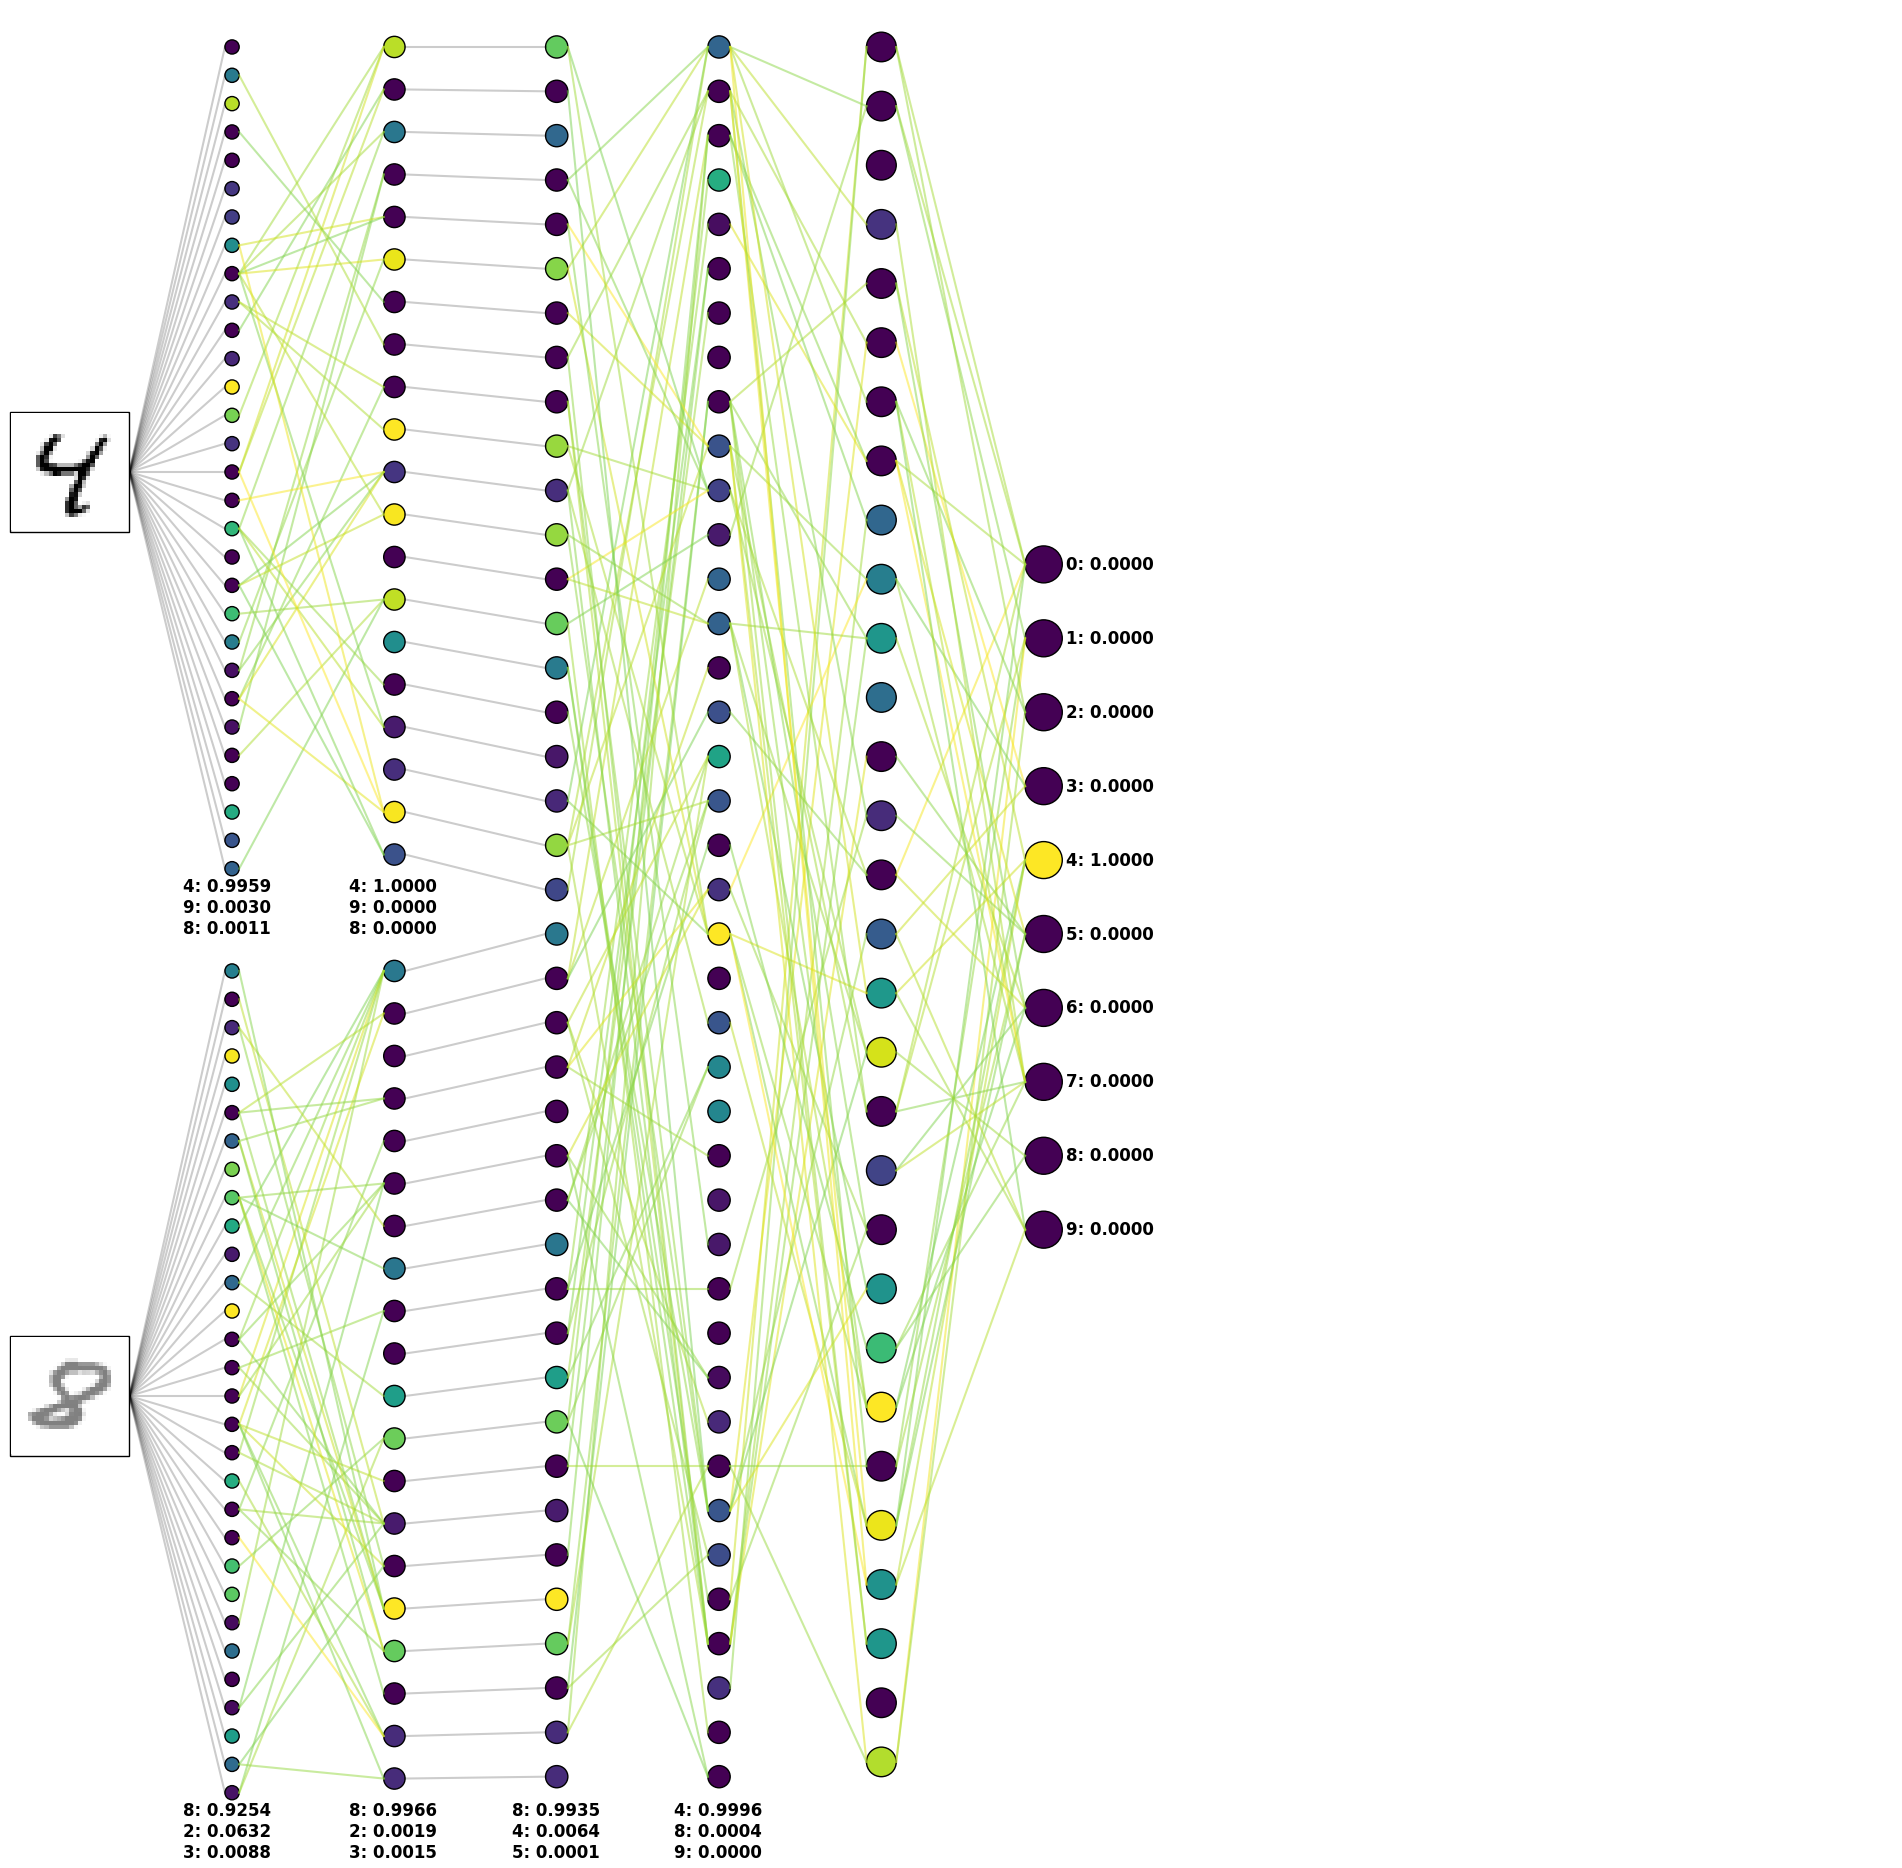

In [82]:
display_double_visual_field_mnist_nn_execution(
    model_t1,
    output_models=output_models,
    k=3,
    max_neurons=300,
    weight_plot_threshold=0.8,
    x_data=x_test,
    left_vf_digit=(6, 1),
    right_vf_digit=(61, 0.5),
)